# Empirical hardness analysis

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
import numpy as np

from colosseum.hardness.analysis import HardnessAnalysisParams, run_scenario_analysis
from colosseum.mdp import BaseMDP
from colosseum.mdp.simple_grid import SimpleGridContinuous

np.random.seed(42)
```
````
`````

In [1]:
import numpy as np

from colosseum.hardness.analysis import HardnessAnalysisParams, run_scenario_analysis
from colosseum.mdp import BaseMDP
from colosseum.mdp.simple_grid import SimpleGridContinuous

np.random.seed(42)

2022-10-15 16:42:58.784166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 16:42:58.871352: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-10-15 16:42:59.262248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:42:59.262287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:42:59.262291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Measuring and understanding the hardness of MDPs represent a fundamental step in the development of a {{rl}} benchmark.
This tutorial introduces the hardness measures available in {{col}} and illustrates how to carry out the empirical analysis presented in the paper for the measures available in the package and for custom ones.


## Measures of hardness

The three efficiently computable theoretical measures of hardness available are the diameter, the environmental value norm, and the {{subgaps}}.
Their code names in the package can be obtained from the 
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.get_available_hardness_measures">``get_available_hardness_measures``</a> 
function.

There are two ways in which it is possible to compute the measures for a 
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP">``BaseMDP``</a>
object.
You can either call the corresponding properties,
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.diameter">``diameter``</a>,
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.value_norm">``value_norm``</a>, and
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.sum_reciprocals_suboptimality_gaps">``sum_reciprocals_suboptimality_gaps``</a>,
or alternatively you can use the
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.get_measure_from_name">``get_measure_from_name``</a>
function, which takes the code name of the measure as input.

In [2]:
# Instantiate an MDP
mdp = SimpleGridContinuous(seed=0, size=4, p_rand=0.01, n_starting_states=3)

# Diameter
print(f"Diameter: {mdp.diameter:.2f}")
# Environmental value norm
print(f"Environmental value norm: {mdp.value_norm:.2f}")
# Sum of the reciprocals of the suboptimality gaps
print(f"Sum of the reciprocals of the suboptimality gaps: {mdp.sum_reciprocals_suboptimality_gaps:.2f}")

# Or alternatively
# for measure_name in BaseMDP.get_available_hardness_measures():
#  print(f"{measure_name}: {mdp.get_measure_from_name(measure_name):.2f}")

Diameter: 6.05


Environmental value norm: 0.50
Sum of the reciprocals of the suboptimality gaps: 361.30


## Hardness scenarios

The accompanying {{paper}} proposes four scenarios to analyse the two different types of complexities that arise in {{rl}}: the _visitation complexity_, which relates to the difficulty of visiting all the states, and the _estimation complexity_, which relates to the discrepancy between the optimal policy and the best policy an agent can derive from a given estimate of the transition and reward kernels.

In order to define a scenario, we need to create a
[``HardnessAnalysisParams``](../pdoc_files/colosseum/hardness/analysis.html#HardnessAnalysisParams)
object, which encodes the configurations for the scenario.
The [``run_scenario_analysis``](../pdoc_files/colosseum/hardness/analysis.html#run_scenario_analysis) function runs a `HardnessAnalysisParams` and produces the corresponding figure.
Note the ``run_scenario_analysis`` is built on top of the [``get_varying_parameter_dfs``](../pdoc_files/colosseum/hardness/analysis.html#get_varying_parameter_dfs), which computes the hardness measures for the MDP instances.
If multiprocessing is enabled ``get_varying_parameter_dfs`` will use multiple cores.

The [``SimpleGridContinuous``](../pdoc_files/colosseum/mdp/simple_grid/base.html#SimpleGridContinuous) class is used as a running example for the tutorial.

### Scenario 1
We vary the probability ``p_rand`` that an MDP executes a random action instead of the action selected by an agent. As ``p_rand`` approaches one, value estimation becomes easier, since outcomes depend less on agent choices. However, intentionally visiting states becomes harder.

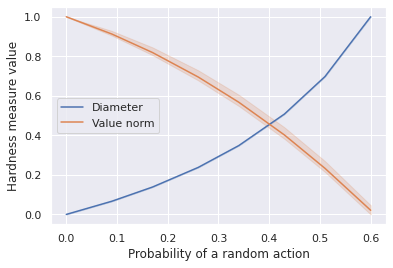

In [3]:
SCENARIO_1_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_rand",
    varying_params_name_clean="Probability of a random action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_1_SimpleGridContinuous)

### Scenario 2
We vary the probability ``p_lazy`` that an MDP stays in the same state instead of executing
the action selected by an agent. Contrary to increasing p_rand, increasing ``p_lazy`` never benefits
exploration. Increasing ``p_lazy`` decreases estimation complexity and increases visitation complexity.

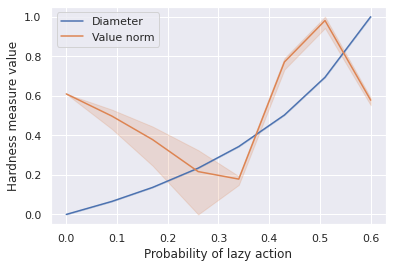

In [4]:
SCENARIO_2_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_lazy",
    varying_params_name_clean="Probability of lazy action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_2_SimpleGridContinuous)

### Scenario 3
We vary the number of states across MDPs from the same family. Increasing the number of states simultaneously increases the estimation complexity and the visitation complexity.

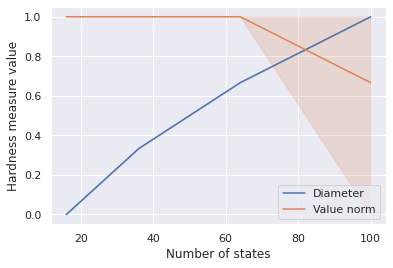

In [5]:
SCENARIO_3_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="size",
    varying_params_name_clean="Number of states",
    varying_params_values=np.arange(4, 12, 2),
    fixed_params=dict(make_reward_stochastic=True, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_3_SimpleGridContinuous)

### Scenario 4
We vary the number of states across MDPs from the same family with a fixed value of ``p_rand = 0.1``. Increasing the number of states simultaneously increases the estimation complexity and the visitation complexity.

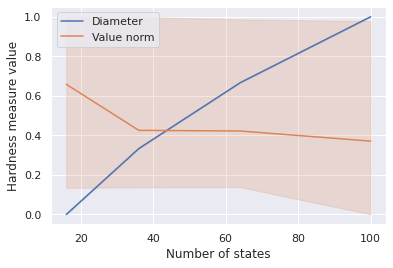

In [6]:
SCENARIO_4_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="size",
    varying_params_name_clean="Number of states",
    varying_params_values=np.arange(4, 12, 2),
    fixed_params=dict(make_reward_stochastic=True, p_rand=0.1, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_4_SimpleGridContinuous)

### Custom scenario
Running custom scenarios with custom measures of hardness is straightforward since it is possible to specify custom measures of hardness in the ``HardnessAnalysisParams`` configuration.

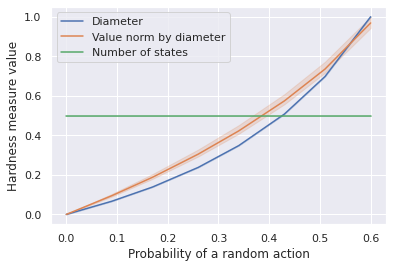

In [7]:
def number_of_states(mdp: BaseMDP) -> float:
    """
    A trivial measure of hardness that simply counts the number of states.
    """
    return mdp.n_states

def value_norm_by_diameter(mdp: BaseMDP) -> float:
    """
    A measure of hardness obtained by multiplying the diameter by the environmental value norm.
    """
    return mdp.diameter * mdp.value_norm
    
custom_scenario_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_rand",
    varying_params_name_clean="Probability of a random action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    hardness_measures=("diameter", value_norm_by_diameter, number_of_states),
    n_seeds_mdp=3,
)

run_scenario_analysis(custom_scenario_SimpleGridContinuous)

In [8]:
import shutil
shutil.rmtree("tmp", ignore_errors=True)
shutil.rmtree("cached_hardness_measures", ignore_errors=True)